In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг 1: Загрузка данных и начальная информация о DataFrame

In [2]:
train_types = {
  "row_id": "int64",
  "timestamp": "int64",
  "user_id": "int32",
  "content_id": "int16",
  "content_type_id": "int8",
  "task_container_id": "int16",
  "user_answer": "int8",
  "answered_correctly": "int8",
  "prior_question_elapsed_time": "float32", 
  "prior_question_had_explanation": "boolean"
}

train_df = pd.read_csv('data/train-001.csv', sep=',', nrows=20000000, header=0, dtype=train_types)
# train_df = pd.read_csv('data/train-001.csv', sep=',', header=0, dtype=train_types)

# Посмотреть на данные:
display(train_df.head())
display(train_df.tail())

# На их структуру:
display(train_df.info())

# Купить к следующему заданию ещё планку оперативки:
print('Распределение памяти:')
display(train_df.memory_usage(deep=True))

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
19999995,19999995,4257733356,429186902,839,0,1241,3,0,17000.0,True
19999996,19999996,4257758761,429186902,725,0,1242,3,0,23000.0,True
19999997,19999997,4257788331,429186902,979,0,1243,1,1,17000.0,True
19999998,19999998,4359822324,429186902,8890,0,1206,1,1,17000.0,True
19999999,19999999,4359848530,429186902,4260,0,1244,0,1,6000.0,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000000 entries, 0 to 19999999
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 629.4 MB


None

Распределение памяти:


Index                                   128
row_id                            160000000
timestamp                         160000000
user_id                            80000000
content_id                         40000000
content_type_id                    20000000
task_container_id                  40000000
user_answer                        20000000
answered_correctly                 20000000
prior_question_elapsed_time        80000000
prior_question_had_explanation     40000000
dtype: int64

## Шаг 2: Разделение данных
У нас в одной куче train_df лежит две сущности: lectures и questions. Так быть не должно, нужно их разделять. Наибольший интерес представляет questions_df, так как судя по записям на Kaggle, данный датасет предназначен для обучения прогнозированию успешности сдачи тестов студентами.

In [3]:
# Разделение данных на лекции и тесты
if train_df.empty:
  raise Exception('Этот блок уже выполнен, исходный датафрейм уже пустой и не может быть использован.')
lectures_df = train_df[train_df['content_type_id'] == 1]
questions_df = train_df[train_df['content_type_id'] == 0]
# Да, не самое изящное решение, но я вынужден экономить оперативную память.
train_df.drop(train_df.index, inplace= True)

# Удалить из lectures_df колонки, относящиеся только к questions_df
lectures_df = lectures_df.drop(['content_type_id', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation'], axis=1)
# Удалить не нужную уже колонку:
questions_df = questions_df.drop(['content_type_id'], axis=1)

## Шаг 3: Анализ целостности и качества данных
### 3.1 Проверка на наличие пропусков

In [4]:
print('Пропуски в данных по лекциям:\n', lectures_df.isnull().sum(), '\n')
print('Пропуски в данных по тестам:\n', questions_df.isnull().sum())

Пропуски в данных по лекциям:
 row_id               0
timestamp            0
user_id              0
content_id           0
task_container_id    0
dtype: int64 

Пропуски в данных по тестам:
 row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       192960
prior_question_had_explanation    192960
dtype: int64


<font color='orange'>Пропуски не обнаружены</font> кроме колонок ```prior_question_elapsed_time``` и ```prior_question_had_explanation```, где они имеют место быть по условиям задачи.

### 3.2 Проверка на наличие дубликатов

In [4]:
print('Проверка дубликатов в лекциях:\n', lectures_df.duplicated().sum(), '\n')
print('Проверка дубликатов в тестах:\n', questions_df.duplicated().sum())

Проверка дубликатов в лекциях:
 0 

Проверка дубликатов в тестах:
 0


<font color='orange'>Дубликаты не обнаружены</font>

### 3.3 Дополнение датафреймов связанными данными
Ключём для связывания датафрейма train с двумя другими является колонка ```content_id```. 

In [5]:
# Загружаем детализирующую информацию по лекциям:
lectures_temp_df = pd.read_csv('data/lectures.csv', sep=',', header=0)
lectures_temp_df['lecture_id'] = lectures_temp_df['lecture_id'].astype('Int16')
lectures_temp_df['tag'] = lectures_temp_df['tag'].astype('Int16')
lectures_temp_df['part'] = lectures_temp_df['part'].astype('Int16')
lectures_temp_df['type_of'] = lectures_temp_df['type_of'].astype('category')

# Загружаем детализирующую информацию по тестам:
questions_temp_df = pd.read_csv('data/questions.csv', sep=',', header=0)
questions_temp_df['question_id'] = questions_temp_df['question_id'].astype('Int16')
questions_temp_df['bundle_id'] = questions_temp_df['bundle_id'].astype('Int16')
questions_temp_df['correct_answer'] = questions_temp_df['correct_answer'].astype('Int8')
questions_temp_df['part'] = questions_temp_df['part'].astype('Int16')

# Преобразуем стоку с тегами в массив
questions_temp_df['tags'] = questions_temp_df['tags'].str.split()

lectures_df = lectures_df.merge(
  lectures_temp_df,
  left_on='content_id',
  right_on='lecture_id',
  how='left'
)
# Удаляем лишнее, в том числе идентификаторы
lectures_df = lectures_df.drop(['row_id','content_id','lecture_id'], axis=1)

questions_df = questions_df.merge(
  questions_temp_df,
  left_on='content_id',
  right_on='question_id',
  how='left'
)
# Удаляем лишнее, в том числе идентификаторы
# Так же нем не интересны номера ответов
questions_df = questions_df.drop(['row_id','content_id','question_id', 'correct_answer', 'user_answer'], axis=1)

print('Дополненая таблица лекций:\n')
display(lectures_df)

print('Дополненая таблица тестов:\n')
display(questions_df)

Дополненая таблица лекций:



,timestamp,user_id,task_container_id,tag,part,type_of
0,653762,2746,14,129,2,intention
1,10183847,5382,21,40,1,concept
2,1424348597,5382,104,43,5,concept
3,1425557777,5382,121,58,5,concept
4,405813029,8623,59,99,1,concept
...,...,...,...,...,...,...
389872,3739690327,429186902,1056,74,4,concept
389873,3740714348,429186902,1070,178,1,concept
389874,3916764184,429186902,1143,108,5,concept
389875,4146042369,429186902,1203,128,5,concept


Дополненая таблица тестов:



,timestamp,user_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,bundle_id,part,tags
0,0,115,1,1,NaN,<NA>,5692,5,[151]
1,56943,115,2,1,37000.0,False,5716,5,[168]
2,118363,115,0,1,55000.0,False,128,1,"[131, 149, 92]"
3,131167,115,3,1,19000.0,False,7860,1,"[131, 104, 81]"
4,137965,115,4,1,11000.0,False,7922,1,"[131, 149, 92]"
...,...,...,...,...,...,...,...,...,...
19610118,4257733356,429186902,1241,0,17000.0,True,839,2,"[155, 163, 81, 29]"
19610119,4257758761,429186902,1242,0,23000.0,True,725,2,"[17, 56, 92, 102]"
19610120,4257788331,429186902,1243,1,17000.0,True,979,2,"[148, 32, 38, 81]"
19610121,4359822324,429186902,1206,1,17000.0,True,8890,5,[79]


## Шаг 4. Визуализация и распределение

In [6]:
# Понимаем, что 'tag' и 'part' это скорее котегориальные данные, странно смотреть по ним mean и std, но пусть будет.
print('Общая статистика по Лекциям:')
display(lectures_df[['timestamp','tag','part']].describe())
print('Общая статистика по Тестам:')
display(questions_df[['timestamp','answered_correctly','prior_question_elapsed_time', 'prior_question_had_explanation', 'part']].describe())

Общая статистика по Лекциям:


,timestamp,tag,part
count,3.898770e+05,389877.0,389877.0
mean,7.662893e+09,91.011245,4.089108
std,1.134528e+10,54.436111,1.676463
min,0.000000e+00,0.0,1.0
25%,8.961802e+08,47.0,2.0
50%,2.926442e+09,85.0,5.0
75%,9.492352e+09,139.0,5.0
max,8.470816e+10,187.0,7.0


Общая статистика по Тестам:


,timestamp,answered_correctly,prior_question_elapsed_time,part
count,1.961012e+07,1.961012e+07,1.953207e+07,19610123.0
mean,7.585776e+09,6.576616e-01,2.541894e+04,4.082278
std,1.149454e+10,4.744922e-01,1.989928e+04,1.673958
min,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,5.140849e+08,0.000000e+00,1.600000e+04,2.0
50%,2.622147e+09,1.000000e+00,2.100000e+04,5.0
75%,9.780702e+09,1.000000e+00,2.966600e+04,5.0
max,8.594535e+10,1.000000e+00,3.000000e+05,7.0


### 4.1 Визуализировать распределение верных и не верных ответов

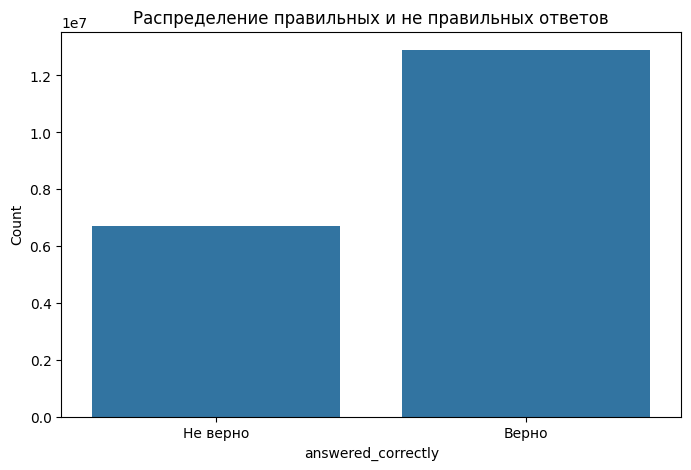

In [7]:
# Подсчитаем количество правильных и неправильных ответов
response_counts = questions_df['answered_correctly'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=response_counts.index, y=response_counts.values)
plt.title('Распределение правильных и не правильных ответов')
# plt.xlabel('Верный ответ (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Не верно', 'Верно'])
plt.show()


### 4.2 Распределение числовых переменных

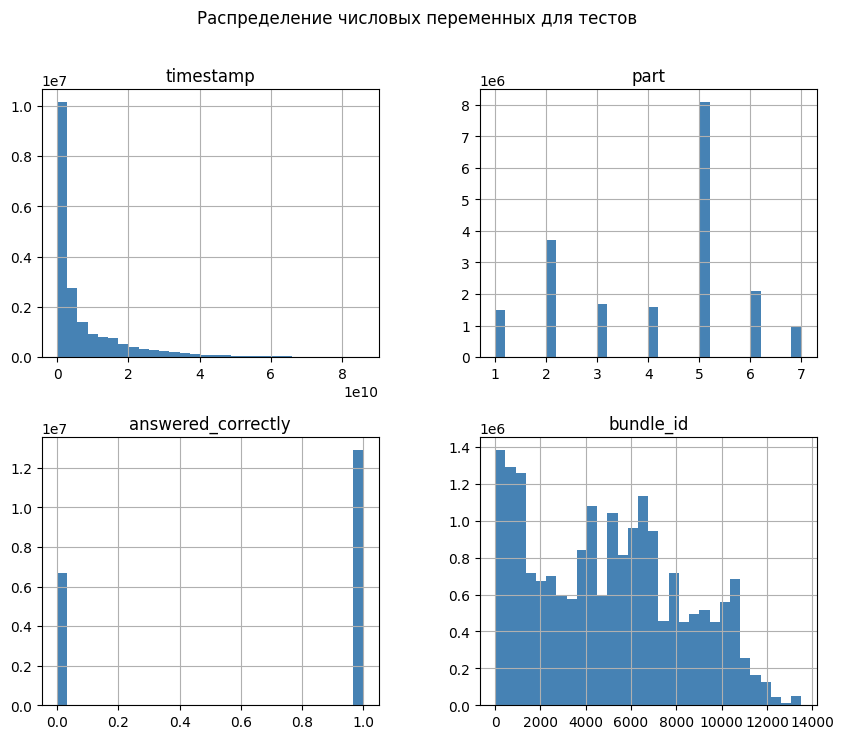

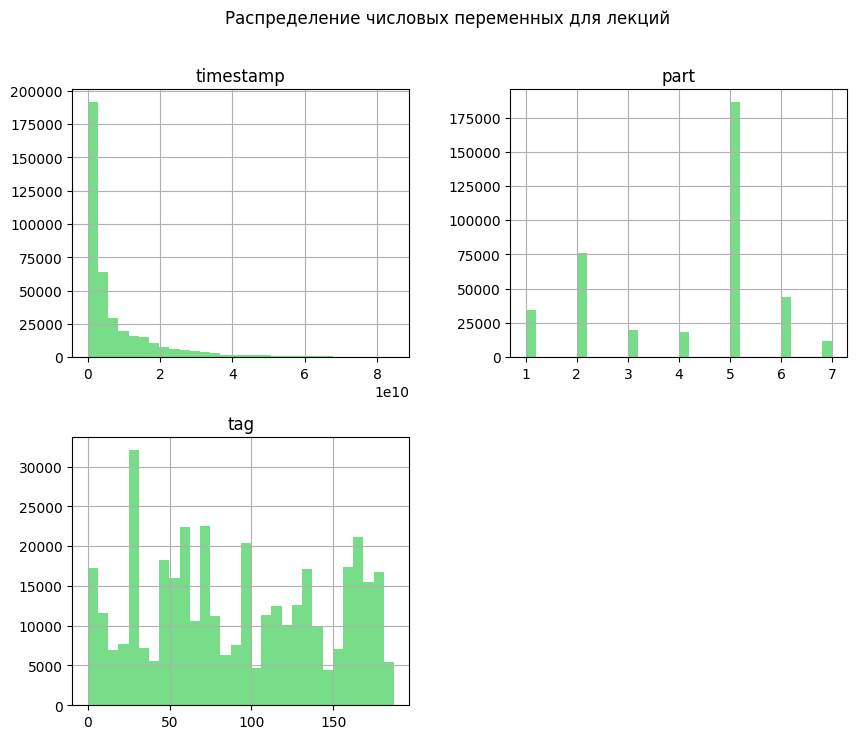

In [8]:
# Распределение числовых переменных
questions_df.hist(column=['timestamp','part','answered_correctly', 'bundle_id'], bins=30, figsize=(10, 8), color='steelblue')
plt.suptitle('Распределение числовых переменных для тестов')
plt.show()

lectures_df.hist(column=['timestamp','part','tag'], bins=30, figsize=(10, 8), color='#77dd88')
plt.suptitle('Распределение числовых переменных для лекций')
plt.show()

## Шаг 5. Анализ выбросов и аномалий

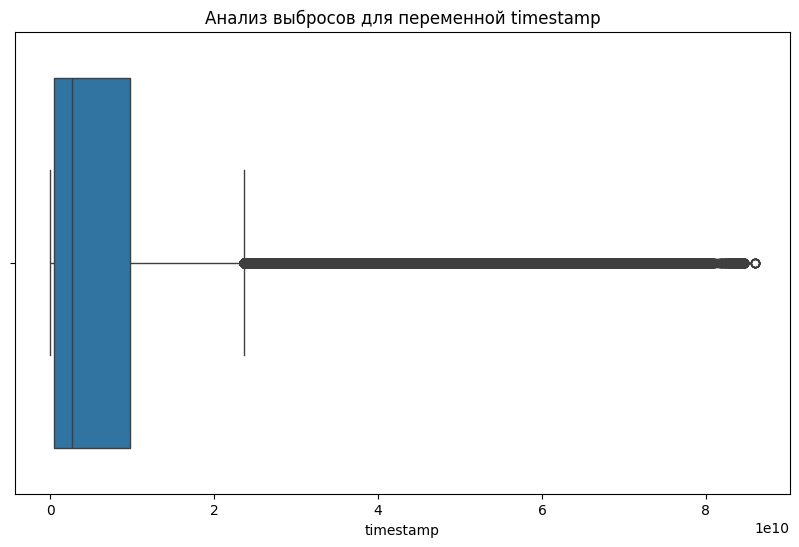

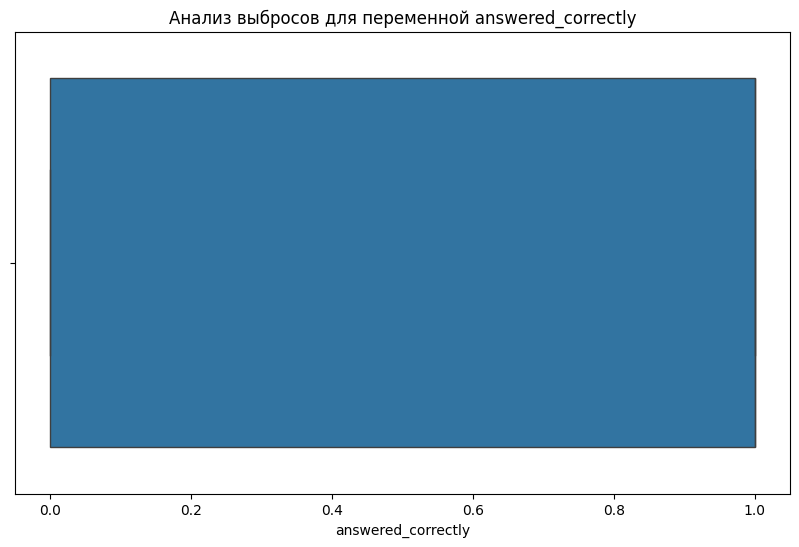

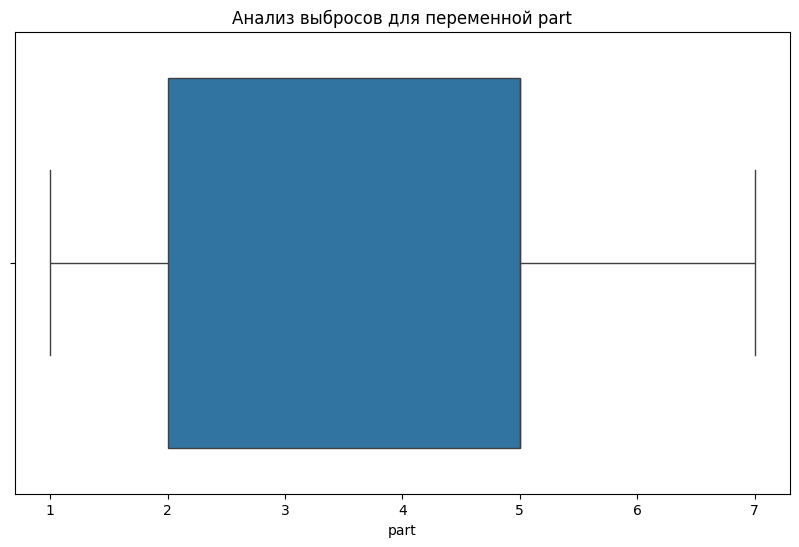

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_outliers(df):    
    # Построение boxplot для каждого числового столбца
    for column in ['timestamp', 'answered_correctly', 'part']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df[column], orient='h')
        plt.title(f'Анализ выбросов для переменной {column}')
        plt.show()

# Анализ выбросов для всех числовых переменных
analyze_outliers(questions_df)

<font color='orange'>Отсутствует явная необходимость очистки данных от выбросов.</font>

## Шаг 6. Взаимосвязь между признаками

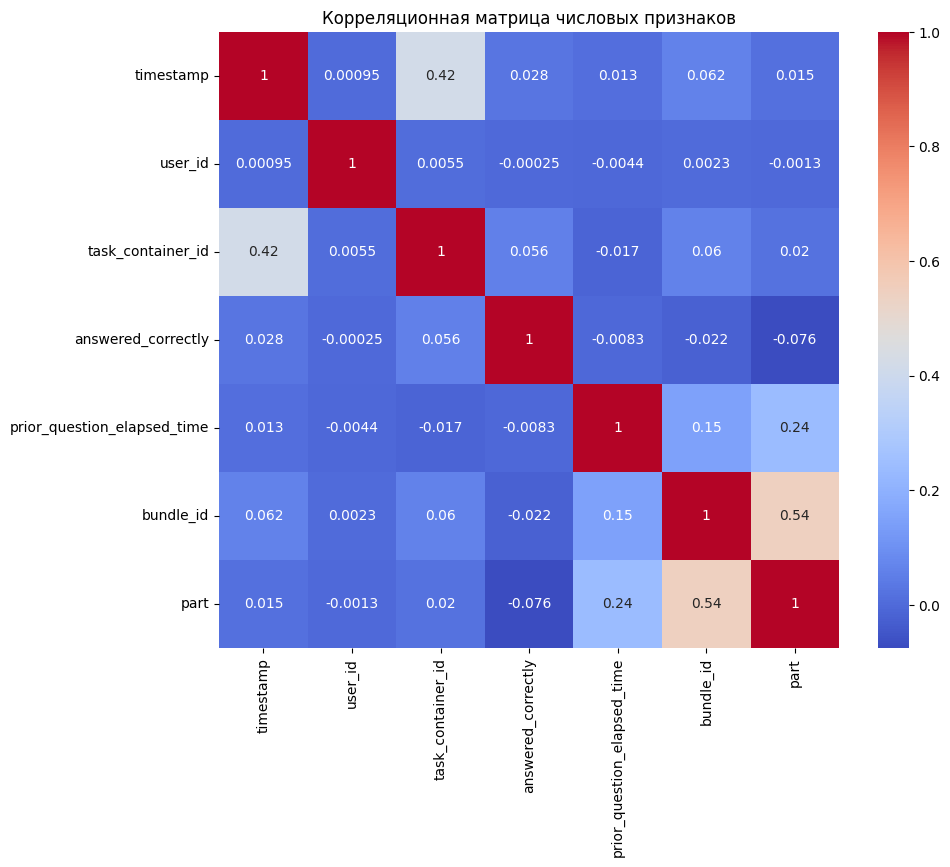

In [10]:
# Выбор только числовых признаков
numeric_cols = questions_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64'])

# Корреляционная матрица для числовых признаков
corr_matrix = numeric_cols.corr()

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

**Выводы по матрице корреляции**:

1. bundle_id:

- Наблюдается умеренно сильная корреляция между переменной bundle_id и part, значение по модулю - 0.54. Вероятно это не более чем отражение структуры устройства тестов, в которой группы совместной выдачи вопросов как-то соотносятся с разделами, к которым эти вопросы относятся. Для нас не представляет интереса.

2. task_container_id:

- Наблюдается умеренная корреляция между параметрами task_container_id и timestamp, значение 0.42. Опять же, вероятно речь об устройстве процесса тестирования. Вероятно пакеты выдаваемых вопросов каким-то образом распределены по времени.


## Шаг 7. Пробная гипотеза и её проверка
### Распределение количества верных ответов по студентам
Попробуем проверить, есть ли связь между количеством сданных каждым студентом тестов и успешностью его ответов. Сделаем это с помошью графика, в котором покажем среднее количество верных и не верных ответов для каждого студента и разобьём их на 4 группы.

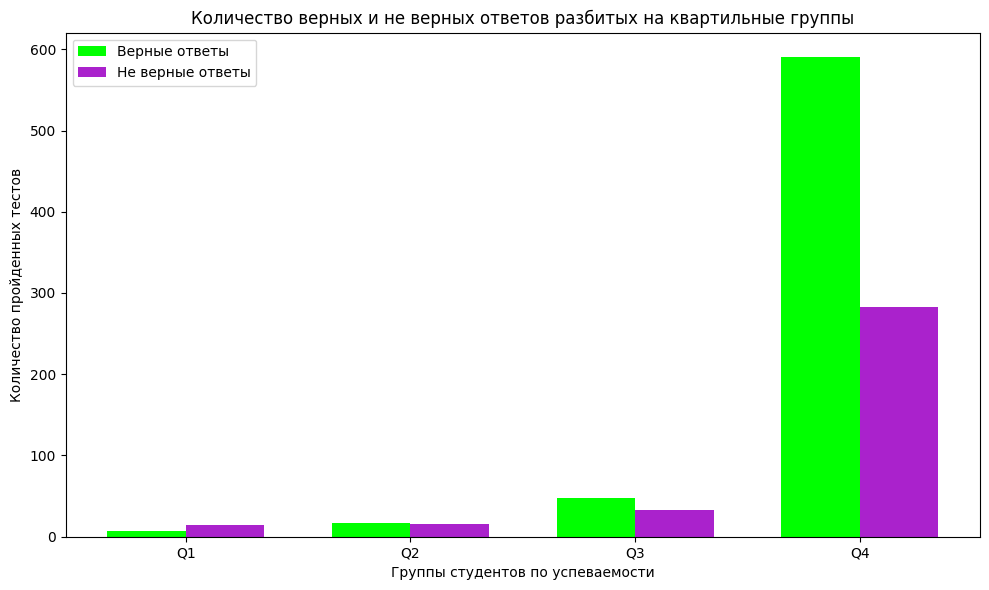

In [11]:

# Группировка по user_id (студентам) и подсчет правильных и неправильных ответов
user_stats = questions_df.groupby('user_id')['answered_correctly'].agg(['sum', 'count']).reset_index()
user_stats.columns = ['user_id', 'correct_answers', 'total_answers']

# Вычисляем количество неправильных ответов
user_stats['incorrect_answers'] = user_stats['total_answers'] - user_stats['correct_answers']

# Разбиваем пользователей на квартильные группы по количеству правильных ответов
user_stats['quartile'] = pd.qcut(user_stats['correct_answers'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Рассчитываем средние значения для каждой квартильной группы
quartile_stats = user_stats.groupby('quartile').agg({
    'correct_answers': 'mean',
    'incorrect_answers': 'mean'
}).reset_index()

# Рисуем график
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(quartile_stats))

# Столбцы для правильных и неправильных ответов
plt.bar(index, quartile_stats['correct_answers'], bar_width, label='Верные ответы', color='lime')
plt.bar([i + bar_width for i in index], quartile_stats['incorrect_answers'], bar_width, label='Не верные ответы', color='#aa22cc')

# Настройка графика
plt.xlabel('Группы студентов по успеваемости')
plt.ylabel('Количество пройденных тестов')
plt.title('Количество верных и не верных ответов разбитых на квартильные группы')
plt.xticks([i + bar_width / 2 for i in index], quartile_stats['quartile'])
plt.legend()
plt.tight_layout()
plt.show()

#### <font color='lime'>Вывод 1:</font> Чем больше студент сдаёт тесты, тем лучше у него результаты (соотношение верных и не верных ответов).

## Итог.
Мы завершили предварительное исследование и подготовку предоставленных данных. Результат может быть использован для дальшейшего более глубокого исследования и обучения предсказательных моделей.